In [1]:
import os
import time
import csv  
import random
import copy
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageFont, ImageDraw 
from matplotlib import pyplot as plt
from IPython import display 
from tqdm import tqdm
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True
torch.cuda.is_available()

import shutil
if os.path.isdir('evaluation'):
    shutil.rmtree('evaluation')

import shutil
if os.path.isdir('saved_images'):
    shutil.rmtree('saved_images')
    os.mkdir('saved_images')

In [2]:
# Z = vis
# H = inf

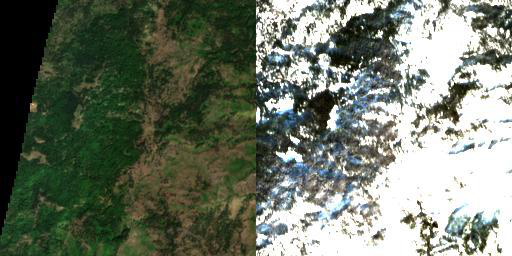

In [3]:
dataset_path = "C:/Users/supercomp/MapTransfer/dataset_sum2win/dataset_cyclegan"
# example
Image.open(dataset_path+'/example/20.0_40.0_476.jpeg')

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = dataset_path + '/train'
VAL_DIR = dataset_path + '/valid'
TEST_DIR = dataset_path + '/test'
EVAL_DIR = 'evaluation'
BATCH_SIZE = 4
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 1 # было 0, 0ю5 - лучше

LAMBDA_CYCLE = 50 # было 10
NUM_WORKERS = 0
NUM_EPOCHS = 3
LOAD_MODEL = False
SAVE_MODEL = True
PIN_MEMORY = False 
CHECKPOINT_gen_inf = "geninf.pth"
CHECKPOINT_GEN_vis= "genvis.pth"
CHECKPOINT_CRITIC_inf= "criticinf.pth"
CHECKPOINT_CRITIC_vis= "criticvis.pth"

transform = A.Compose(
    [A.Resize(width=256, height=256),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()], additional_targets={"image0": "image"}
)

In [5]:
def save_some_examples(gen1, gen2, val_loader, epoch, folder, show_images=False):
    iterator = iter(val_loader)
    x, y = next(iterator)
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen1.eval()
    gen2.eval()
    if not os.path.isdir(folder):
        os.makedirs(folder)

    with torch.no_grad():
        y_fake = gen1(x)
        x_fake = gen2(y)
        save_image(y_fake, folder + f"/y_gen_{epoch:03d}.png")
        save_image(x_fake, folder + f"/x_gen_{epoch:03d}.png")
        if epoch == 0:
            save_image(x * 1 + 0, folder + f"/input.png")
            save_image(y * 1 + 0, folder + f"/label.png")
    gen1.train()
    gen2.train()
    
    if show_images:
        f, ax = plt.subplots(1,4, figsize=(12,8))
        x = x.squeeze().cpu().permute(1,2,0)
        y = y.squeeze().cpu().permute(1,2,0)
        y_fake = y_fake.squeeze().cpu().permute(1,2,0)
        x_fake = x_fake.squeeze().cpu().permute(1,2,0)

        ax[0].imshow(x)
        ax[1].imshow(x_fake)
        ax[2].imshow(y)
        ax[3].imshow(y_fake)

        plt.show()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything()

In [6]:
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, :256, :]
        target_image = image[:, 256:, :]

        augmentations = transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        return input_image, target_image


if __name__ == "__main__":
    dataset = MapDataset(TRAIN_DIR)
    loader = DataLoader(dataset, batch_size=5)
    for x, y in loader:
        print(x.shape)
        save_image(x, "x.png")
        save_image(y, "y.png")
        break

torch.Size([5, 3, 256, 256])


In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

torch.Size([5, 1, 30, 30])


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)

if __name__ == "__main__":
    test()

torch.Size([2, 3, 256, 256])


100%|██████████| 2263/2263 [23:37<00:00,  1.60it/s, inf_fake=0.212, inf_real=0.865]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


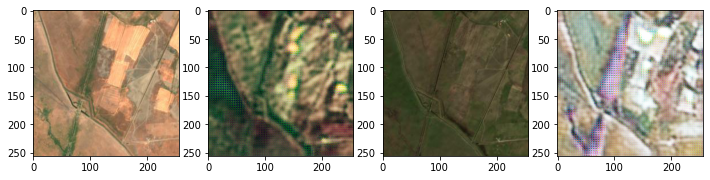

 16%|█▌        | 356/2263 [03:38<19:24,  1.64it/s, inf_fake=0.177, inf_real=0.892]

In [9]:
def train_fn(disc_inf, disc_vis, gen_vis, gen_inf, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, epoch):
    inf_reals = 0
    inf_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (visual, infrared) in enumerate(loop):
        visual = visual.to(DEVICE)
        infrared = infrared.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_infrared = gen_inf(visual)
            D_inf_real = disc_inf(infrared)
            D_inf_fake = disc_inf(fake_infrared.detach())
            inf_reals += D_inf_real.mean().item()
            inf_fakes += D_inf_fake.mean().item()
            D_inf_real_loss = mse(D_inf_real, torch.ones_like(D_inf_real))
            D_inf_fake_loss = mse(D_inf_fake, torch.zeros_like(D_inf_fake))
            D_inf_loss = D_inf_real_loss + D_inf_fake_loss

            fake_visual = gen_vis(infrared)
            D_vis_real = disc_vis(visual)
            D_vis_fake = disc_vis(fake_visual.detach())
            D_vis_real_loss = mse(D_vis_real, torch.ones_like(D_vis_real))
            D_vis_fake_loss = mse(D_vis_fake, torch.zeros_like(D_vis_fake))
            D_vis_loss = D_vis_real_loss + D_vis_fake_loss

            # put it togethor
            D_loss = (D_inf_loss + D_vis_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_inf_fake = disc_inf(fake_infrared)
            D_vis_fake = disc_vis(fake_visual)
            loss_G_inf= mse(D_inf_fake, torch.ones_like(D_inf_fake))
            loss_G_vis= mse(D_vis_fake, torch.ones_like(D_vis_fake))

            # cycle loss
            cycle_visual = gen_vis(fake_infrared)
            cycle_infrared = gen_inf(fake_visual)
            cycle_visual_loss = l1(visual, cycle_visual)
            cycle_infrared_loss = l1(infrared, cycle_infrared)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_visual = gen_vis(visual)
            identity_infrared = gen_inf(infrared)
            identity_visual_loss = l1(visual, identity_visual)
            identity_infrared_loss = l1(infrared, identity_infrared)

            # add all togethor
            G_loss = (
                loss_G_vis
                + loss_G_inf
                + cycle_visual_loss * LAMBDA_CYCLE
                + cycle_infrared_loss * LAMBDA_CYCLE
                + identity_infrared_loss * LAMBDA_IDENTITY
                + identity_visual_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_infrared, f"saved_images/infrared_{epoch:03d}_{idx:04d}.png")
            save_image(fake_visual, f"saved_images/visual_{epoch:03d}_{idx:04d}.png")

        loop.set_postfix(inf_real=inf_reals/(idx+1), inf_fake=inf_fakes/(idx+1))



def main():
    disc_inf = Discriminator(in_channels=3).to(DEVICE)
    disc_vis = Discriminator(in_channels=3).to(DEVICE)
    gen_vis = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_inf = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_inf.parameters()) + list(disc_vis.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_vis.parameters()) + list(gen_inf.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_gen_inf, gen_inf, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_vis, gen_vis, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_inf, disc_inf, opt_disc, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_vis, disc_vis, opt_disc, LEARNING_RATE,
        )

    train_dataset = MapDataset(root_dir=TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    val_dataset = MapDataset(root_dir=VAL_DIR)
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=PIN_MEMORY,
    )
    
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(disc_inf, disc_vis, gen_vis, gen_inf, train_loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler, epoch)

        if SAVE_MODEL:
            save_checkpoint(gen_inf, opt_gen, filename=CHECKPOINT_gen_inf)
            save_checkpoint(gen_vis, opt_gen, filename=CHECKPOINT_GEN_vis)
            save_checkpoint(disc_inf, opt_disc, filename=CHECKPOINT_CRITIC_inf)
            save_checkpoint(disc_vis, opt_disc, filename=CHECKPOINT_CRITIC_vis)
        
        save_some_examples(gen_inf, gen_vis, val_loader, epoch, folder=EVAL_DIR, show_images=True)



if __name__ == "__main__":
    main()

In [ ]:
gen_inf = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_vis = Generator(img_channels=3, num_residuals=9).to(DEVICE)
opt_gen = optim.Adam(
        list(gen_vis.parameters()) + list(gen_inf.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999))
load_checkpoint(
            CHECKPOINT_gen_inf, gen_inf, opt_gen, LEARNING_RATE,
        )
gen_inf.eval()
gen_vis.eval()

=> Loading checkpoint


Generator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv): S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


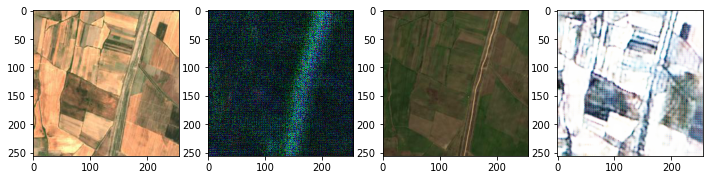

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


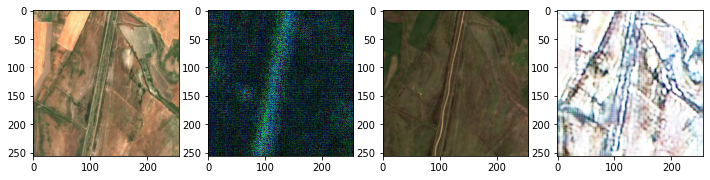

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


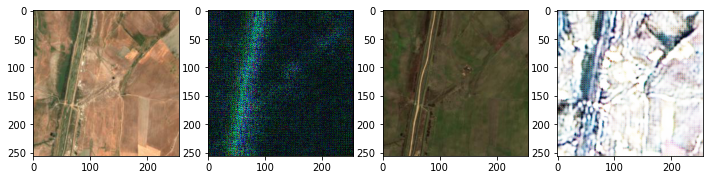

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


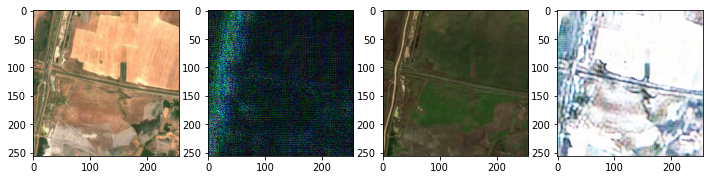

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


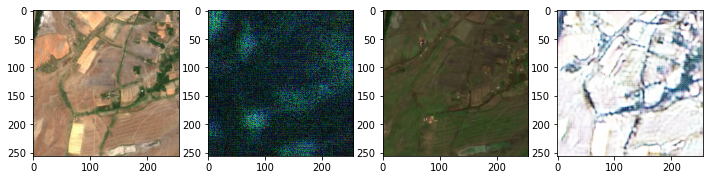

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


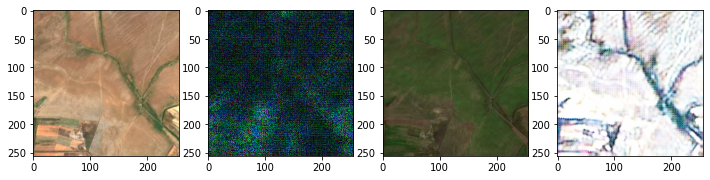

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


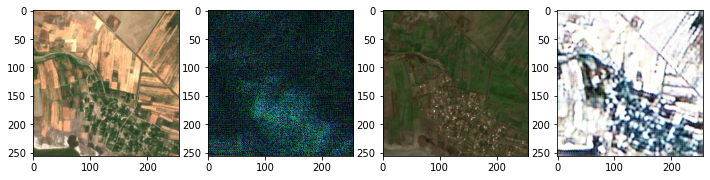

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


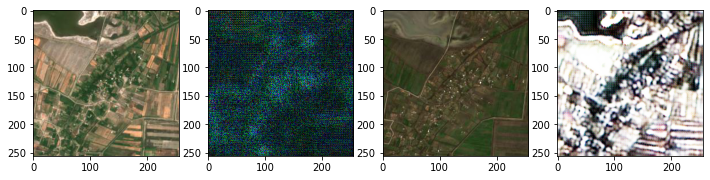

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


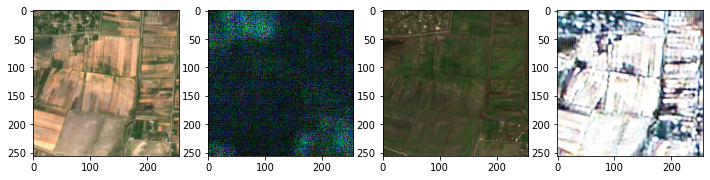

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


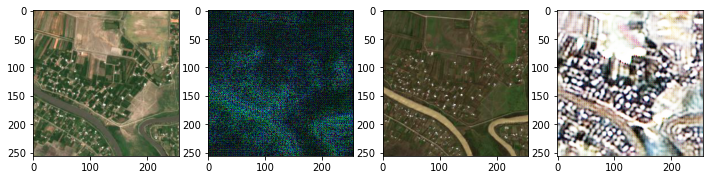

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


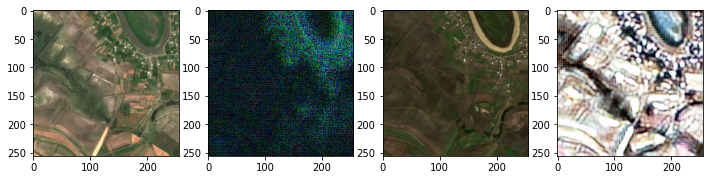

In [ ]:
test_dataset = MapDataset(root_dir=TEST_DIR)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=PIN_MEMORY,
)
for i, (x, y) in enumerate(test_loader):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    y_fake = gen_inf(x)
    x_fake = gen_vis(y)
    f, ax = plt.subplots(1,4, figsize=(12,8))
    x = x.squeeze().cpu().permute(1,2,0).detach().numpy()
    y = y.squeeze().cpu().permute(1,2,0).detach().numpy()
    y_fake = y_fake.squeeze().cpu().permute(1,2,0).detach().numpy()
    x_fake = x_fake.squeeze().cpu().permute(1,2,0).detach().numpy()

    ax[0].imshow(x)
    ax[1].imshow(x_fake)
    ax[2].imshow(y)
    ax[3].imshow(y_fake)
    
    plt.show()
    if i == 10:
        break
